# Crashlytics

In this notebook we investigate [US Car Accident Data](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents). 

Our goal is to create a classifier that can predict the severity of a car accident given the other features in the dataset. We will use three methods of classification (Decision Trees, Random Forest, and a Neural Network) and compare the results.


## Update to project goal


Severity is defined rather cryptically in this dataset. According to the [original paper](https://arxiv.org/pdf/1906.05409.pdf) detailing the creation of the dataset, crash severity is a native feature of the data, which was collected from both Bing and MapQuest. Bing and MapQuest use different scales for severity, [1,4] for Bing and [0,4] for MapQuest, the similarity between the two ranking systems being that a larger number indicates a more severe accident. The only insight into the meaning of accident severity is that it is typically correlated with duration, distance, and delay where:
- **Duration**: how long was traffic impacted by the accident
- **Distance**: how far did the impact on traffic extend
- **Delay**: how much delay in traffic flow was caused

However, these three features are very poorly recorded in the dataset. In the majority of records, crash duration is recorded as either 30 or 45 minutes and crash distance is recorded as 0 miles or approximately 0 miles. Delay is nowhere to be found. So it would be very difficult to determine whether severity is actually determined by some combination of duration, distance, and delay.

Though the original intent of this project was to create a car accident severity predictor that could predict the severity of an accident given the circumstances the accident occured under, the classifiers are actually predicting how either Bing or MapQuest would classify the severity of an accident given the less-than-ideal data those services either generate or receive.

---
---

## Import/install dependencies, create SparkSession, and read in data

In [57]:
try:
    import pyspark
except ModuleNotFoundError:
    !pip3 install pyspark
    import pyspark
try:
    import pandas as pd
except ModuleNotFoundError:
    !pip3 install pandas
    import pandas as pd
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt
try:
    import numpy as np
except ModuleNotFoundError:
    !pip3 install numpy
    import numpy as np

In [58]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString, PCA, StandardScaler, Tokenizer, Word2Vec
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [59]:
from decision_tree_plot.decision_tree_parser import decision_tree_parse
try:
    from decision_tree_plot.decision_tree_plot import plot_trees
except ModuleNotFoundError:
    !pip3 install jinja2
    from decision_tree_plot.decision_tree_plot import plot_trees

In [60]:
#May need to install java for this to work
ss=SparkSession.builder.master("local").appName("crashlytics").getOrCreate()

In [61]:
rawDf = ss.read.csv("reduced_crash_data.csv", header=True, inferSchema=True)
#rawDf.printSchema()

---
---

## Imbalance in Data

One important characteristic of our dataset is that a crash severity of 2 or 3 is much more common than any other severity ranking, which we will have to consider when building and evaluating our classifiers.

In [62]:
severityCount = rawDf.groupBy(F.col("Severity")).count()
#severityCount.show()

extremeSeverities = rawDf.filter(F.col("Severity") != 3).filter(F.col("Severity") != 2)
#extremeSeverities.show()

---
---

## Data preprocessing

There are a number of steps we need to take to prepare our data for KMeans Clustering and PCA and for use by the various classifiers.

First, we will add a crash duration column derived from the start_time and end_time columns to give our various models a data type they can work with (double) rather than a time. This also allows us to drop the start_time and end_time columns.

In [7]:
cleanedDf = rawDf.withColumn("Duration", (F.col("End_Time").cast("long") - F.col("Start_Time").cast("long"))/60)
cleanedDf = cleanedDf.drop("Start_Time").drop("End_Time")

We will also adjust the range of severity values from [1,4] to [0,3], as some of the models we will be using require that the label values start at 0.

In [8]:
cleanedDf = cleanedDf.withColumn("Severity", F.col("Severity")-1)

Convert categorical string columns into integer indices so that they can be ingested by the models.

In [ ]:
labelIndexer = StringIndexer(inputCols = ["Sunrise_Sunset", "Source"], outputCols = ["DaytimeId", "SourceId"]).fit(rawDf)
cleanedDf = labelIndexer.transform(cleanedDf)

We drop non-categorical string columns that cannot be easily indexed and we do not expect to relevant to determining crash severity.

In [10]:

cleanedDf = cleanedDf.drop("ID", "Airport_Code", "Zipcode", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "City", "County", "Zipcode", "Country", "Timezone", \
                         "Weather_Timestamp", "Wind_Direction", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Turning_Loop", "State", "Street", "Sunrise_Sunset")

For string columns that we may want to keep, we can try using a method to convert the values into vectors that still retain some of the semantic information of the values (by magic). 

The model we tried using for this conversion is called Word2Vec, but, though it succeeded, it increased the dimensionality of our data drastically. We think the increased dimensionality is too large a price to pay for **potentially** retaining some data about the weather during an accident and the description of the accident, which may not even be useful in our classification models.

In [11]:
vectorizeStrings = False

if vectorizeStrings:
    descTokenizer = Tokenizer(inputCol="Description", outputCol="descWords")
    tokenizedDescDf = descTokenizer.transform(cleanedDf)
    descVectorizer = Word2Vec(vectorSize=5, minCount=1, inputCol="descWords", outputCol="descWordsVec")
    descModel = descVectorizer.fit(tokenizedDescDf)
    vectorizedDescriptionDf = descModel.transform(tokenizedDescDf)

    tokenizer_weather = Tokenizer(inputCol="Weather_Condition", outputCol="weatherWords")
    vectorizedDescriptionDf = vectorizedDescriptionDf.fillna({"Weather_Condition": ""})
    tokenizedWeatherDf = tokenizer_weather.transform(vectorizedDescriptionDf)
    weatherVectorizer = Word2Vec(vectorSize=3, minCount=1, inputCol="weatherWords", outputCol="weatherWordsVec")
    weatherModel = weatherVectorizer.fit(tokenizedWeatherDf)
    vectorizedWeatherDf = weatherModel.transform(tokenizedWeatherDf)

    #wordVecData_weather.select("Description", "desc_word2vec", "Weather_Condition", "weather_word2vec").show(420,truncate=False)

    cleanedDf = vectorizedWeatherDf.drop("Description", "Weather_Condition", "desc_words", "weather_words")

else:
    cleanedDf = cleanedDf.drop("Description", "Weather_Condition")

Some of the columns in the dataset have lots of null values, so we replace any null values in those columns with 0. We believe that for these columns 0 is a fairly obvious stand-in value – if the wind chill, precipitation, or wind speed were not recorded they were likely not important factors in the accident.

In [12]:
cleanedDf = cleanedDf.fillna({"Wind_Chill(F)": 0, "Precipitation(in)": 0, "Wind_Speed(mph)": 0})

Our dataframe cleanedDf is now ready for use in KMeans, PCA, and classification.

---
---

## Vectorize our feature columns for use in K-Means clustering and PCA

The rest of the processing we do on our data prefers our table be condensed into a single vectorized column, so we do that here.

For K-Means and PCA we will retain severity in the features column, later for the classifier we will drop that information from the features column.

In [ ]:
#Ignore reamining null values
kmeansAssembler = VectorAssembler(inputCols=cleanedDf.columns, outputCol="features", handleInvalid="skip")
kmeansData = kmeansAssembler.transform(cleanedDf)

lostRecordCount = cleanedDf.count() - kmeansData.count()

In [14]:
print("Lost records due to null values: ", lostRecordCount) 
print("Percentage of total records lost: ", lostRecordCount/cleanedDf.count())

Lost records due to null values:  164
Percentage of total records lost:  0.0164


---

## K-Means Clustering

This data has a large number of features, so we will perform K-Means Clustering to see if we can find some patterns in our data and PCA to better understand which features of our dataset affect crash severity.

In [15]:
def fit_kmeans(df_input,num_cluster_centers=3):
  kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  wcss = model.summary.trainingCost
  
  return clustered_data, wcss

In [ ]:
kValues = range(2, 20)
wcss_scores = []

for k in kValues:
  clustered_data, wcss = fit_kmeans(kmeansData,num_cluster_centers=k)
  wcss_scores.append(wcss)

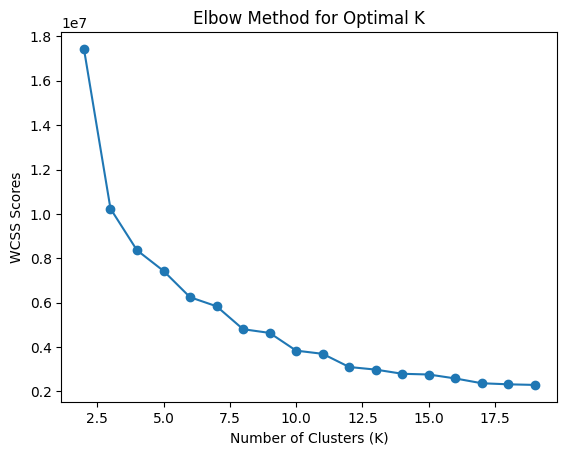

In [17]:
plt.plot(kValues, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

After performing K-Means clustering with 2-20 clusters, there is no obvious candidate for optimal number of clusters. This could indicate that our data does not have well-separated, distinct clusters. Reducing the dimensionality of our data may lead to better results, so after completing PCA and identifying the principle components of our dataset we will revisit K-Means.

---

## PCA

This data has a large number of features, so we will perform PCA to see what the true dimensionality of our data is, and see if we can produce better K-Means results after reducing our data

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(kmeansData)
scaledData = scalerModel.transform(kmeansData)

pca = PCA(k=18, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(scaledData)
result = pcaModel.transform(scaledData)

In [19]:
print("Explained Variance: ", sum(pcaModel.explainedVariance))

Explained Variance:  0.859602581765267


We will find the minimum number of principle components needed to explain at least 95% of the variance. We want to reduce the dimensionality of our data as much as possible but still retain a high amount of the variance.

In [20]:
principleComponents = range(1, 26)
bestPcCount = 1
for pc in principleComponents:
    pca=PCA(k=pc, inputCol="scaledFeatures", outputCol="pcaFeatures")
    pcaModel = pca.fit(scaledData)
    if sum(pcaModel.explainedVariance) > 0.95:
        bestPcCount = pc
        break
bestPca = PCA(k=bestPcCount, inputCol="scaledFeatures", outputCol="pcaFeatures")
bestPcaModel = bestPca.fit(scaledData)
pcaReducedDf = bestPcaModel.transform(scaledData)

In [21]:
print("Principle Components needed for >95% explained variance: ", bestPcCount)
print("Explained Variance: ", sum(bestPcaModel.explainedVariance))

Principle Components needed for >95% explained variance:  22
Explained Variance:  0.9606070875786235


In [22]:
def fit_kmeans_column(df_input,column_name='pcaFeatures',num_cluster_centers=3):
  kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  wcss = model.summary.trainingCost
  
  return clustered_data, wcss

In [23]:
wcss_scores_pca = []

for k in kValues:
  clustered_data, wcss = fit_kmeans_column(pcaReducedDf,column_name="pcaFeatures",num_cluster_centers=k)
  wcss_scores_pca.append(wcss)

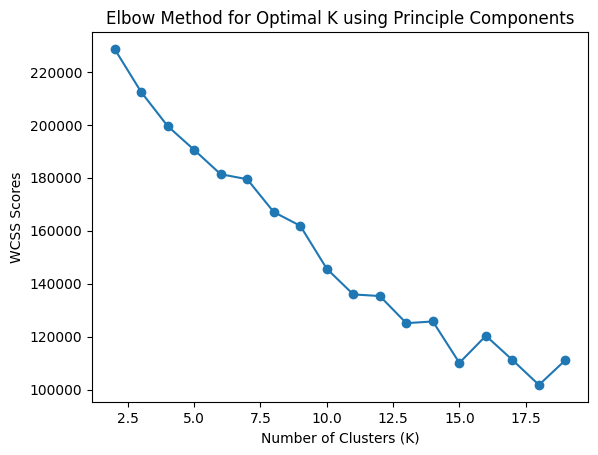

In [24]:
plt.plot(kValues, wcss_scores_pca, marker='o')
plt.title("Elbow Method for Optimal K using Principle Components")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

Unfortunately the results of K-Means clustering are still inconclusive after performing PCA and extracting the principle components of our dataset. Moreover, we were not able to greatly reduce the dimensionality of our data by performing PCA, in order to explain 95% of the variance in our data we needed to retain 21 principle components from 26 features.

---
---

## Vectorize our feature columns for use by classifiers

For the classifier we will drop severity from the features column, as that will be the label column that the classifier will be trying to predict.

We also split our data into a training set and test set, using 75% of the data in training and reserving 25% for testing. As we will be using these two sets for each of the classifiers, we cache them using the persist() command.

In [25]:
classifierAssembler = VectorAssembler(inputCols=cleanedDf.drop("Severity").columns, outputCol="features", handleInvalid="skip")
classifierData = classifierAssembler.transform(cleanedDf)
classifierData = classifierData.withColumn(colName="label", col=F.col("Severity")).drop("Severity")

trainingData, testData = classifierData.randomSplit([0.75, 0.25], seed=42)
trainingData.persist()
testData.persist()

accuracyEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1Evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

---

## Decision Tree Classifier

Create a Decision tree classifier using arbitrary hyperparameters

In [ ]:
dtClassifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=6, minInstancesPerNode=2)
dtModel = dtClassifier.fit(trainingData)
testPredictions = dtModel.transform(testData)

In [27]:
accuracy = accuracyEvaluator.evaluate(testPredictions)
print(f"Accuracy: {accuracy}")

f1 = f1Evaluator.evaluate(testPredictions)
print(f"F1: {f1}")

Accuracy: 0.7701342281879194
F1: 0.77138643423509


We perform hyperparameter tuning on the classifier to identify the best set of hyperparameters.

In [28]:
def trainAndEvaluateDT(trainingData: pyspark.sql.DataFrame, testData: pyspark.sql.DataFrame) -> (pd.DataFrame, int, pyspark.ml.classification.DecisionTreeClassificationModel):
    dtHyperparamsEvaluationDf = pd.DataFrame(columns = ["max depth", "min instances per node", "training f1", "testing f1", "training accuracy", "testing accuracy", "best model"])

    index = 0
    bestIndex = 0
    highestTestF1 = 0
    bestDtModel = None

    maxDepthList = range(2, 10)
    minInstancesPerNodeList = range(1,15)

    for maxDepth in maxDepthList:
        for minInstances in minInstancesPerNodeList:
            seed = 42
            dtClassifier = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=maxDepth, minInstancesPerNode=minInstances, seed=seed)
            dtModel = dtClassifier.fit(trainingData)
            trainingPredictions = dtModel.transform(trainingData)
            testPredictions = dtModel.transform(testData)
            trainingF1 = f1Evaluator.evaluate(trainingPredictions)
            testingF1 = f1Evaluator.evaluate(testPredictions)
            trainingAccuracy = accuracyEvaluator.evaluate(trainingPredictions)
            testingAccuracy = accuracyEvaluator.evaluate(testPredictions)

            dtHyperparamsEvaluationDf.loc[index] = [maxDepth, minInstances, trainingF1, testingF1, trainingAccuracy, testingAccuracy, 0]

            if testingF1 > highestTestF1:
                highestTestF1 = testingF1
                bestIndex = index
                bestDtModel = dtModel

            index += 1

    dtHyperparamsEvaluationDf.loc[bestIndex, "best model"] = 1
    return (dtHyperparamsEvaluationDf, bestIndex, bestDtModel)

In [29]:
dtDf, dtIndex, bestDtModel = trainAndEvaluateDT(trainingData=trainingData, testData=testData)
dtF1 = dtDf.loc[dtIndex, "testing f1"]
dtAccuracy = dtDf.loc[dtIndex, "testing accuracy"]

In [30]:
print(dtDf.loc[dtIndex])

max depth                  9.000000
min instances per node    11.000000
training f1                0.836207
testing f1                 0.818894
training accuracy          0.835212
testing accuracy           0.818372
best model                 1.000000
Name: 108, dtype: float64


Our classifier achieved an f1 score on validation data of 0.85 with 85% accuracy. Let's visualize our decision tree to see if we can better understand how it is making its predictions.

In [31]:
def visualizeDT(dtModel: pyspark.ml.classification.DecisionTreeClassificationModel, modelPath: str, outputPath: str):
    modelPath = modelPath
    parsedTree = decision_tree_parse(dtModel, ss, modelPath)
    column = dict([(str(idx), i) for idx, i in enumerate(classifierData.columns)])
    plot_trees(parsedTree, column = column, output_path = outputPath)

In [ ]:
visualizeDT(dtModel=bestDtModel, modelPath="bestDecisionTreeModel", outputPath="bestDecisionTreeVisualization.html")

The visualization of the decision tree is dense and hard to decipher. Later we will see how many features we need to keep to achieve similar amounts of predictive ability, and the visualization should be easier to understand if that succeeds.

---

## Classification with Random Forest

We will now see how a random forest classifier performs on the data.

In [33]:
randomForestClassifier = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=5, minInstancesPerNode=2)
randomForestModel = randomForestClassifier.fit(trainingData)
testPredictions = randomForestModel.transform(testData)

In [34]:
accuracy = accuracyEvaluator.evaluate(testPredictions)
print(f"Accuracy: {accuracy}")

f1 = f1Evaluator.evaluate(testPredictions)
print(f"F1: {f1}")

Accuracy: 0.7214765100671141
F1: 0.7051670712603004


In [35]:
def trainAndEvaluateRandomForest(trainingData: pyspark.sql.DataFrame, testData: pyspark.sql.DataFrame) -> (pd.DataFrame, int):
    randomForestEvaluationDf = pd.DataFrame(columns = ["max depth", "min instances per node", "training f1", "testing f1", "training accuracy", "testing accuracy", "best model"])

    index = 0
    bestIndex = 0
    highestTestF1 = 0

    maxDepthList = range(2, 10)
    minInstancesPerNodeList = range(1,15)

    for maxDepth in maxDepthList:
        for minInstances in minInstancesPerNodeList:
            seed=42
            randomForestClassifier = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=maxDepth, minInstancesPerNode=minInstances, seed=seed)
            randomForestModel = randomForestClassifier.fit(trainingData)
            trainingPredictions = randomForestModel.transform(trainingData)
            testPredictions = randomForestModel.transform(testData)
            trainingF1 = f1Evaluator.evaluate(trainingPredictions)
            testingF1 = f1Evaluator.evaluate(testPredictions)
            trainingAccuracy = accuracyEvaluator.evaluate(trainingPredictions)
            testingAccuracy = accuracyEvaluator.evaluate(testPredictions)

            randomForestEvaluationDf.loc[index] = [maxDepth, minInstances, trainingF1, testingF1, trainingAccuracy, testingAccuracy, 0]

            if testingF1 > highestTestF1:
                highestTestF1 = testingF1
                bestIndex = index

            index += 1

    randomForestEvaluationDf.loc[bestIndex, "best model"] = 1
    return (randomForestEvaluationDf, bestIndex)


In [36]:
randomForestDf, randomForestIndex = trainAndEvaluateRandomForest(trainingData=trainingData, testData=testData)
randomForestF1 = randomForestDf.loc[randomForestIndex, "testing f1"]
randomForestAccuracy = randomForestDf.loc[randomForestIndex, "testing accuracy"]

In [37]:
print(randomForestDf.loc[randomForestIndex])

max depth                 9.000000
min instances per node    3.000000
training f1               0.796531
testing f1                0.774279
training accuracy         0.795894
testing accuracy          0.774329
best model                1.000000
Name: 100, dtype: float64


The random forest classifier performed slightly worse than the decision tree classifier, predicting severity with about 3% less accuracy than the decision tree.

---

## Classification with a neural network (multilayer perceptron)

Neural Networks are generally outperformed by tree-based methods such as decision trees and random forest in classifying tabular data, so we would expect that this method of classification would perform worst on our dataset. 

First we create an MLP Classifier with arbitrary hidden layer sizes. The input layer must have 25 nodes to ingest all 25 features of our dataset and the output layer must have 4 nodes for each of the 4 severity classes. The hyperparameter we will be tuning here is the hidden layer sizes i.e. the layers of nodes between the input and output layers.

In [40]:
mlpClassifier = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers=[25,12,4,16,4,4])
mlpModel = mlpClassifier.fit(trainingData)
testPredictions = mlpModel.transform(testData)

In [41]:
accuracy = accuracyEvaluator.evaluate(testPredictions)
print(f"Accuracy: {accuracy}")

f1 = f1Evaluator.evaluate(testPredictions)
print(f"F1: {f1}")

Accuracy: 0.5985738255033557
F1: 0.4698800176436732


In [42]:
def trainAndEvaluateMLP(trainingData: pyspark.sql.DataFrame, testData: pyspark.sql.DataFrame) -> (pd.DataFrame, int):
    mlpHyperparamsEvaluationDf = pd.DataFrame(columns = ["hidden layer sizes", "training f1", "testing f1", "training accuracy", "testing accuracy", "best model"])

    index = 0
    bestIndex = 0
    highestTestF1 = 0

    hiddenLayerSizes = [[10], [20], [30], [10, 10], [10, 20], [10, 30], [20, 10], [20, 20], [20, 30], [30, 10], [30, 20], [30, 30]]

    for layerSize in hiddenLayerSizes:
        seed=42
        mlpClassifier = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers=[25] + layerSize + [4], seed=seed)
        mlpModel = mlpClassifier.fit(trainingData)
        trainingPredictions = mlpModel.transform(trainingData)
        testPredictions = mlpModel.transform(testData)
        trainingF1 = f1Evaluator.evaluate(trainingPredictions)
        testingF1 = f1Evaluator.evaluate(testPredictions)
        trainingAccuracy = accuracyEvaluator.evaluate(trainingPredictions)
        testingAccuracy = accuracyEvaluator.evaluate(testPredictions)

        mlpHyperparamsEvaluationDf.loc[index] = [layerSize, trainingF1, testingF1, trainingAccuracy, testingAccuracy, 0]

        if testingF1 > highestTestF1:
            highestTestF1 = testingF1
            bestIndex = index

        index += 1

    mlpHyperparamsEvaluationDf.loc[bestIndex, "best model"] = 1
    return (mlpHyperparamsEvaluationDf, bestIndex)

In [43]:
mlpDf, mlpIndex = trainAndEvaluateMLP(trainingData=trainingData, testData=testData)
mlpF1 = mlpDf.loc[mlpIndex, "testing f1"]
mlpAccuracy = dtDf.loc[mlpIndex, "testing accuracy"]

In [44]:
print(mlpDf.loc[mlpIndex])

hidden layer sizes    [20, 20]
training f1           0.602006
testing f1             0.59081
training accuracy     0.633119
testing accuracy         0.625
best model                   1
Name: 7, dtype: object


As expected, the MLP classifier performed much worse than either tree-based classifier. With two hidden layers with 20 nodes, the model only achieved an F1 score of 0.6. It is possible that with better tuning of the hidden layer sizes this approach would work better.

## Results of classification

After training and tuning three classification models (decision tree, random forest, and multilayer perceptron) we can conclude that, of the models examined, the **Decision tree model is the most powerful predictor of car crash severity**, given this specific dataset. Neither the decision tree nor the multilayer perceptron classifier was able to achieve an F1 score >90% on the test data.

What is important to note is that none of the models performed exceptionally well, especially considering the heavy imbalance in the data, by randomly guessing severity 2 or 3 a model would do alright. Perhaps this implies that there is no strong correlation between crash severity and any of the features in the dataset.

Shown below are the results of the various classifiers plotted against one another.

In [45]:
def plotClassifierPerformance(classifierLabels: list[str], accuracyScores: list[float], f1Scores: list[float], title: str, xTitle: str, outputPath: str = ""):
    fig, ax = plt.subplots()

    plt.title(title)
    plt.xlabel(xTitle)
    plt.ylabel('Score')

    plt.ylim(0, 1)

    x = np.arange(len(classifierLabels))
    ax.set_xticks(x)
    ax.set_xticklabels(classifierLabels)

    ax.bar(x - 0.2, accuracyScores, width=0.4, label="Accuracy", align="center", alpha=0.7)

    ax.bar(x + 0.2, f1Scores, width=0.4, label="F1 Score", align="center", alpha=0.7)

    ax.legend()

    #Save the figure when running on ICDS
    if outputPath != "":
        plt.savefig(outputPath)

    #Show figure in local mode
    plt.show()

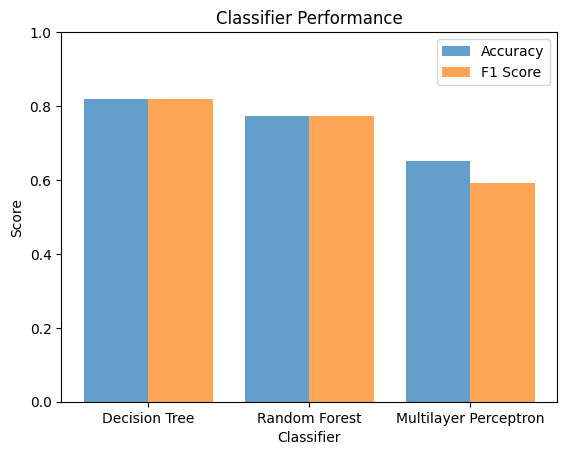

In [46]:
classifiers = ['Decision Tree', 'Random Forest', 'Multilayer Perceptron']
accuracyScores = [dtAccuracy, randomForestAccuracy, mlpAccuracy] 
f1Scores = [dtF1, randomForestF1, mlpF1]

plotClassifierPerformance(classifierLabels=classifiers, accuracyScores=accuracyScores, f1Scores=f1Scores, title="Classifier Performance", xTitle="Classifier")

---
---

## Exploring the minimum number of columns needed for similar results

Even though we dropped many of the columns from this dataset at the onset for being non-categorical strings, it seems likely that many of the remaining columns also should not be needed to predict crash severity. So we will drop as many of the columns as we can to produce similar results with the decision tree model. Afterwards, we will use the reduced feature set to visualize a decision tree, as the above decision tree visualization is too complex to really parse and understand.

This should be an interesting exploration into the true nature of the severity classification used in this dataset, hopefully illuminating some of the characteristics used to rank the severity of an accident.

It will also be interesting to see whether the best set of hyperparameters remains the same as the set found earlier or changes with each new set of features.

We divide the features into five categories:
- **Source**: source of the record (MapQuest or Bing)
- **Road Features**: features that pertain to the characteristics of the road itself and the surroundings
- **Location Features**: features that describe where in the world the accident occurred
- **Environmental Features**: features describing the weather and time of day
- **Accident Features**: features of the accident itself - distance and duration

In [47]:
sourceFeatures = ["SourceId"]
roadEngineeringFeatures = ["Traffic_Signal", "Traffic_Calming", "Stop", "Station", "Roundabout", "Railway", "No_Exit", "Junction", "Give_Way", "Crossing", "Bump", "Amenity"]
locationFeatures = ["Start_Lat", "Start_Lng"]
environmentalFeatures = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "DaytimeId"]
accidentFeatures = ["Distance(mi)", "Duration"]

First we will train and evaluate the model five times, each time with a different set of features omitted. We will see if there are any trends we can identify and then proceed to two and then to three and then to four omitted feature sets.

In [48]:
def vectorizeAndTestDT(vectorAssembler: VectorAssembler) -> (pd.DataFrame, int, pyspark.ml.classification.DecisionTreeClassificationModel):
    classifierDataDT = vectorAssembler.transform(cleanedDf)
    classifierDataDT = classifierDataDT.withColumn(colName="label", col=F.col("Severity")).drop("Severity")

    trainingDataDT, testDataDT = classifierDataDT.randomSplit([0.75, 0.25], seed=42)
    trainingDataDT.persist()
    testDataDT.persist()

    return trainAndEvaluateDT(trainingData=trainingDataDT, testData=testDataDT)

In [49]:
assemblerNoSource = VectorAssembler(inputCols=roadEngineeringFeatures+locationFeatures+environmentalFeatures+accidentFeatures, outputCol="features", handleInvalid="skip")
assemblerNoRoad = VectorAssembler(inputCols=sourceFeatures+locationFeatures+environmentalFeatures+accidentFeatures, outputCol="features", handleInvalid="skip")
assemblerNoLocation = VectorAssembler(inputCols=sourceFeatures+roadEngineeringFeatures+environmentalFeatures+accidentFeatures, outputCol="features", handleInvalid="skip")
assemblerNoEnvironment = VectorAssembler(inputCols=sourceFeatures+roadEngineeringFeatures+locationFeatures+accidentFeatures, outputCol="features", handleInvalid="skip")
assemblerNoAccident = VectorAssembler(inputCols=sourceFeatures+roadEngineeringFeatures+locationFeatures+environmentalFeatures, outputCol="features", handleInvalid="skip")

noSourceDf, noSourceIndex, noSourceModel = vectorizeAndTestDT(vectorAssembler=assemblerNoSource)
noRoadDf, noRoadIndex, noRoadModel = vectorizeAndTestDT(vectorAssembler=assemblerNoRoad)
noLocationDf, noLocationIndex, noLocationModel = vectorizeAndTestDT(vectorAssembler=assemblerNoLocation)
noEnvironmentDf, noEnvironmentIndex, noEnvironmentModel = vectorizeAndTestDT(vectorAssembler=assemblerNoEnvironment)
noAccidentDf, noAccidentIndex, noAccidentModel = vectorizeAndTestDT(vectorAssembler=assemblerNoAccident)

In [50]:
print("No source features: ")
print(noSourceDf.loc[noSourceIndex])
print()
print("No road features: ")
print(noRoadDf.loc[noRoadIndex])
print()
print("No location features: ")
print(noLocationDf.loc[noLocationIndex])
print()
print("No environmental features: ")
print(noEnvironmentDf.loc[noEnvironmentIndex])
print()
print("No accident features: ")
print(noAccidentDf.loc[noAccidentIndex])

No source features: 
max depth                  9.000000
min instances per node    11.000000
training f1                0.836207
testing f1                 0.818894
training accuracy          0.835212
testing accuracy           0.818372
best model                 1.000000
Name: 108, dtype: float64

No road features: 
max depth                 9.000000
min instances per node    6.000000
training f1               0.840016
testing f1                0.823742
training accuracy         0.838835
testing accuracy          0.822987
best model                1.000000
Name: 103, dtype: float64

No location features: 
max depth                 9.000000
min instances per node    9.000000
training f1               0.654506
testing f1                0.600016
training accuracy         0.668680
testing accuracy          0.616611
best model                1.000000
Name: 106, dtype: float64

No environmental features: 
max depth                 9.000000
min instances per node    2.000000
training f1     

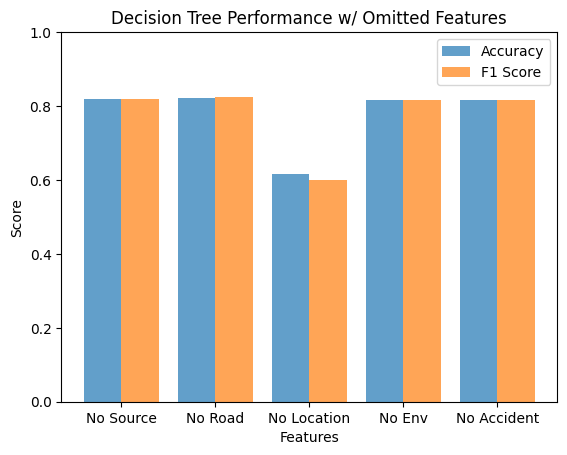

In [51]:
setsOfFourNames = ["No Source", "No Road", "No Location", "No Env", "No Accident"]
setsOfFourAccuracyScores = [noSourceDf.loc[noSourceIndex, "testing accuracy"], noRoadDf.loc[noRoadIndex, "testing accuracy"], noLocationDf.loc[noLocationIndex, "testing accuracy"], noEnvironmentDf.loc[noEnvironmentIndex, "testing accuracy"], noAccidentDf.loc[noAccidentIndex, "testing accuracy"]]
setsOfFourF1Scores = [noSourceDf.loc[noSourceIndex, "testing f1"], noRoadDf.loc[noRoadIndex, "testing f1"], noLocationDf.loc[noLocationIndex, "testing f1"], noEnvironmentDf.loc[noEnvironmentIndex, "testing f1"], noAccidentDf.loc[noAccidentIndex, "testing f1"]]

plotClassifierPerformance(classifierLabels=setsOfFourNames, accuracyScores=setsOfFourAccuracyScores, f1Scores=setsOfFourF1Scores, title="Decision Tree Performance w/ Omitted Features", xTitle="Features")

The location features seem to have the largest impact on accuracy, so we will now test using just two feature sets, where one of the sets will be location features. We'll also test using just the location features.

In [52]:
assemblerLocSource = VectorAssembler(inputCols=sourceFeatures+locationFeatures, outputCol="features", handleInvalid="skip")
assemblerLocRoad = VectorAssembler(inputCols=roadEngineeringFeatures+locationFeatures, outputCol="features", handleInvalid="skip")
assemblerLocEnvironment = VectorAssembler(inputCols=environmentalFeatures+locationFeatures, outputCol="features", handleInvalid="skip")
assemblerLocAccident = VectorAssembler(inputCols=accidentFeatures+locationFeatures, outputCol="features", handleInvalid="skip")
assemblerLoc = VectorAssembler(inputCols=locationFeatures, outputCol="features", handleInvalid="skip")

locSourceDf, locSourceIndex, locSourceModel = vectorizeAndTestDT(vectorAssembler=assemblerLocSource)
locRoadDf, locRoadIndex, locRoadModel = vectorizeAndTestDT(vectorAssembler=assemblerLocRoad)
locEnvironmentDf, locEnvironmentIndex, locEnvironmentModel = vectorizeAndTestDT(vectorAssembler=assemblerLocEnvironment)
locAccidentDf, locAccidentIndex, locAccidentModel = vectorizeAndTestDT(vectorAssembler=assemblerLocAccident)
locDf, locIndex, locModel = vectorizeAndTestDT(vectorAssembler=assemblerLoc) 

In [53]:
print("Loc + source: ")
print(locSourceDf.loc[locSourceIndex])
print()
print("Loc + road: ")
print(locRoadDf.loc[locRoadIndex])
print()
print("Loc + environment: ")
print(locEnvironmentDf.loc[locEnvironmentIndex])
print()
print("Loc + accident: ")
print(locAccidentDf.loc[locAccidentIndex])
print()
print("Only location: ")
print(locDf.loc[locIndex])

Loc + source: 
max depth                 9.000000
min instances per node    1.000000
training f1               0.833966
testing f1                0.829265
training accuracy         0.832959
testing accuracy          0.827757
best model                1.000000
Name: 98, dtype: float64

Loc + road: 
max depth                 9.000000
min instances per node    2.000000
training f1               0.830314
testing f1                0.815844
training accuracy         0.830585
testing accuracy          0.815779
best model                1.000000
Name: 99, dtype: float64

Loc + environment: 
max depth                 9.000000
min instances per node    2.000000
training f1               0.843635
testing f1                0.821710
training accuracy         0.842324
testing accuracy          0.820889
best model                1.000000
Name: 99, dtype: float64

Loc + accident: 
max depth                 9.000000
min instances per node    3.000000
training f1               0.838245
testing f1       

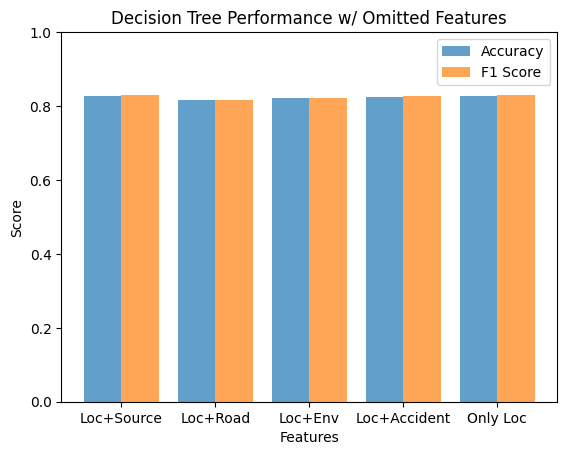

In [54]:
locationNames = ["Loc+Source", "Loc+Road", "Loc+Env", "Loc+Accident", "Only Loc"]
locationAccuracyScores = [locSourceDf.loc[locSourceIndex, "testing accuracy"], locRoadDf.loc[locRoadIndex, "testing accuracy"], locEnvironmentDf.loc[locEnvironmentIndex, "testing accuracy"], locAccidentDf.loc[locAccidentIndex, "testing accuracy"], locDf.loc[locIndex, "testing accuracy"]]
locationF1Scores = [locSourceDf.loc[locSourceIndex, "testing f1"], locRoadDf.loc[locRoadIndex, "testing f1"], locEnvironmentDf.loc[locEnvironmentIndex, "testing f1"], locAccidentDf.loc[locAccidentIndex, "testing f1"], locDf.loc[locIndex, "testing f1"]]

plotClassifierPerformance(classifierLabels=locationNames, accuracyScores=locationAccuracyScores, f1Scores=locationF1Scores, title="Decision Tree Performance w/ Omitted Features", xTitle="Features")

These results are surprising. The best performance on testing data was from the combination of road and location features, but by just keeping the location features (Start Latitude, and Start Longitude), the model was able to predict the crash severity with 90% accuracy. Perhaps this implies that MapQuest and Bing have a bias towards classifying accidents as either severity 2 or 3 based on region. Latitude and longitude should, after all, not have any real impact on crash severity.

## Visualizing a decision tree that classifies strictly based on latitude and longitude.

The visualization produced by the decision tree classifier generated after hyperparameter tuning was too dense to parse, so hopefully by reducing the feature set to the bare minimum (only latitude and longitude information), we can better understand how the decision tree is doing classification.

In [55]:
visualizeDT(dtModel=locModel, modelPath="locDecisionTreeModel", outputPath="locDecisionTreeVisualization.html")

The decision tree is still difficult to parse, but it does seem clear that there is a reporting bias for accident severity 2 or 3 based on the location of the accident, which is interesting.

In [56]:
ss.stop()